# Computer Vision - AV-HuBERT Downstream Task Research

## Install Modules
This section installs necessary python packages for the other sections. Run it first.

In [111]:
!git clone https://github.com/facebookresearch/av_hubert.git

!cd avhubert
!git submodule init
!git submodule update
!pip install scipy
!pip install sentencepiece
!pip install python_speech_features
!pip install scikit-video

%cd fairseq
%pip install ./

fatal: destination path 'av_hubert' already exists and is not an empty directory.
/bin/bash: line 0: cd: avhubert: No such file or directory
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
^C
ERROR: Operation cancelled by user
[Errno 2] No such file or directory: 'fairseq'
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert
ERROR: Directory './' is not installable. Neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


## Preprocess Dataset for AV-HuBERT

1. Install necessary tools for preprocessing

In [ ]:
# !mkdir -p ./data/misc/
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2 -O ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !bzip2 -d ./data/misc/shape_predictor_68_face_landmarks.dat.bz2
# !wget --content-disposition https://github.com/mpc001/Lipreading_using_Temporal_Convolutional_Networks/raw/master/preprocessing/20words_mean_face.npy -O ./data/misc/20words_mean_face.npy

2. Download a video from online

In [ ]:
# !wget --content-disposition https://dl.fbaipublicfiles.com/avhubert/demo/avhubert_demo_video_8s.mp4 -O ./data/clip.mp4

3. Extract mouth ROI.

In [ ]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [ ]:
%cd av_hubert

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert


In [ ]:
#%cd ./av_hubert/avhubert/
%cd ./avhubert

import dlib, cv2, os
import numpy as np
import skvideo
import skvideo.io
from tqdm import tqdm
from preparation.align_mouth import landmarks_interpolate, crop_patch, write_video_ffmpeg
from IPython.display import HTML
from base64 import b64encode

def play_video(video_path, width=200):
  mp4 = open(video_path,'rb').read()
  data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
  return HTML(f"""
  <video width={width} controls>
        <source src="{data_url}" type="video/mp4">
  </video>
  """)

def detect_landmark(image, detector, predictor):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    rects = detector(gray, 1)
    coords = None
    for (_, rect) in enumerate(rects):
        shape = predictor(gray, rect)
        coords = np.zeros((68, 2), dtype=np.int32)
        for i in range(0, 68):
            coords[i] = (shape.part(i).x, shape.part(i).y)
    return coords

def preprocess_video(input_video_path, output_video_path, face_predictor_path, mean_face_path):
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(face_predictor_path)
  STD_SIZE = (256, 256)
  mean_face_landmarks = np.load(mean_face_path)
  stablePntsIDs = [33, 36, 39, 42, 45]
  videogen = skvideo.io.vread(input_video_path)
  frames = np.array([frame for frame in videogen])
  landmarks = []
  for frame in tqdm(frames):
      landmark = detect_landmark(frame, detector, predictor)
      landmarks.append(landmark)
  preprocessed_landmarks = landmarks_interpolate(landmarks)
  rois = crop_patch(input_video_path, preprocessed_landmarks, mean_face_landmarks, stablePntsIDs, STD_SIZE, 
                        window_margin=12, start_idx=48, stop_idx=68, crop_height=96, crop_width=96)
  write_video_ffmpeg(rois, output_video_path, "/usr/bin/ffmpeg")
  return landmarks

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert


In [ ]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert'

In [ ]:
%cd ..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [ ]:
play_video('./clips/clip_1.mp4', width=300)

In [ ]:
import cv2

def get_vid_dims(vid_path):
    # Open the video file
    video = cv2.VideoCapture(vid_path)

    # Get the height and width of the video
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Release the video object
    video.release()

    # Print the height and width
    print("Video Width:", width)
    print("Video Height:", height)


    return width, height

In [ ]:
landmarks_s = []

for clip_idx in range(6):
    clip_idx += 1
    data_dir            = "clips"
    face_predictor_path = f"./misc/shape_predictor_68_face_landmarks.dat"
    mean_face_path      = f"./misc/20words_mean_face.npy"
    origin_clip_path    = f"./{data_dir}/clip_{clip_idx}.mp4"
    mouth_roi_path      = f"./{data_dir}/clip_{clip_idx}_roi.mp4"
    landmarks = preprocess_video(origin_clip_path, mouth_roi_path, face_predictor_path, mean_face_path)
    landmarks = np.array(landmarks)
    vid_width, vid_height = get_vid_dims(origin_clip_path)
    landmarks[:, :, 0] = np.divide(landmarks[:, :, 0], vid_width, dtype="float32") 
    landmarks[:, :, 1] = np.divide(landmarks[:, :, 1], vid_height, dtype="float32") 
    print(landmarks.shape)
    landmarks_s.append(landmarks)
    # play_video(mouth_roi_path)

 66%|██████▌   | 158/240 [00:11<00:05, 14.12it/s]


KeyboardInterrupt: 

In [ ]:
total_landmark_frames = sum([len(l) for l in landmarks_s])
total_landmark_frames

1234

In [ ]:
landmarks_s_arr = np.concatenate(tuple(landmarks_s), axis=0)
landmarks_s_arr.shape

(1234, 68, 2)

### AV-HuBERT (Inference for Features)

In [ ]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [ ]:
import os
# %cd ./avhubert
import cv2
import tempfile
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from fairseq.dataclass.configs import GenerationConfig
from IPython.display import HTML

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def predict(video_path, ckpt_path, user_dir):
  num_frames = int(cv2.VideoCapture(video_path).get(cv2.CAP_PROP_FRAME_COUNT))
  data_dir = tempfile.mkdtemp()
  tsv_cont = ["/\n", f"test-0\t{video_path}\t{None}\t{num_frames}\t{int(16_000*num_frames/25)}\n"]
  label_cont = ["DUMMY\n"]
  with open(f"{data_dir}/test.tsv", "w") as fo:
    fo.write("".join(tsv_cont))
  with open(f"{data_dir}/test.wrd", "w") as fo:
    fo.write("".join(label_cont))
  fairseq.utils.import_user_module(Namespace(user_dir=user_dir))
  modalities = ["video"]
  gen_subset = "test"
  gen_cfg = GenerationConfig(beam=20)
  models, saved_cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  models = [model.eval().cuda() for model in models]
  saved_cfg.task.modalities = modalities
  saved_cfg.task.data = data_dir
  saved_cfg.task.label_dir = data_dir
  task = tasks.setup_task(saved_cfg.task)
  task.load_dataset(gen_subset, task_cfg=saved_cfg.task)
  generator = task.build_generator(models, gen_cfg)

  def decode_fn(x):
      dictionary = task.target_dictionary
      symbols_ignore = generator.symbols_to_strip_from_output
      symbols_ignore.add(dictionary.pad())
      return task.datasets[gen_subset].label_processors[0].decode(x, symbols_ignore)

  itr = task.get_batch_iterator(dataset=task.dataset(gen_subset)).next_epoch_itr(shuffle=False)
  sample = next(itr)
  sample = utils.move_to_cuda(sample)
  hypos = task.inference_step(generator, models, sample)
  ref = decode_fn(sample['target'][0].int().cpu())
  hypo = hypos[0][0]['tokens'].int().cpu()
  hypo = decode_fn(hypo)
  return hypo

def pred(data_dir, clip_idx, model_fname="base_vox_433h.pt"):
  # Linux
  # mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
  # mouth_roi_path = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/data/roi.mp4"
  # ckpt_path      = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/base_vox_433h.pt"
  #mouth_roi_path = "./data/roi.mp4"
  #ckpt_path = "./data/.mp4"
  user_dir       = "/media/joe/DCC4B54EC4B52C20//Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert"
  # mouth_roi_path, ckpt_path = "./data/roi.mp4", "./data/base_vox_433h.pt"
  mouth_roi_path = f"/media/joe/DCC4B54EC4B52C20//Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{data_dir}/clip_{clip_idx}_roi.mp4"
  ckpt_path      = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{model_fname}"
  # mouth_roi_path = f"./{data_dir}/roi.mp4"
  #ckpt_path = "./data/.mp4"
  #user_dir       = "C:/Users/win8t/OneDrive/Desktop/projects/uni-all/av_hubert/avhubert"
  hypo = predict(mouth_roi_path, ckpt_path, user_dir)
  return hypo

hypo_s = []

for clip_idx in range(6):
  clip_idx += 1
  hypo = pred("clips", clip_idx)
  hypo_s.append(hypo)
  
HTML(f"""
  <h3>
    Prediction - {hypo}
  </h3>
  """)

/home/joe/.local/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert/sequence_generator.py:674: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  

In [ ]:
HTML(f"""
  <h3>
    Prediction - {hypo_s[5]}
  </h3>
  """)

### Extract Visual Features

Shape of for visual features is [frames, 768], where 768 is the output of the AV-HuBERT Base Transformer Encoder module for each frame.

In [ ]:
%cd /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
import cv2
import tempfile
import torch
import utils as avhubert_utils
from argparse import Namespace
import fairseq
from fairseq import checkpoint_utils, options, tasks, utils
from IPython.display import HTML

def extract_visual_feature(video_path, ckpt_path, user_dir, is_finetune_ckpt=False):
  utils.import_user_module(Namespace(user_dir=user_dir))
  models, saved_cfg, task = checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
  transform = avhubert_utils.Compose([
      avhubert_utils.Normalize(0.0, 255.0),
      avhubert_utils.CenterCrop((task.cfg.image_crop_size, task.cfg.image_crop_size)),
      avhubert_utils.Normalize(task.cfg.image_mean, task.cfg.image_std)])
  frames = avhubert_utils.load_video(video_path)
  print(f"Load video {video_path}: shape {frames.shape}")
  frames = transform(frames)
  print(f"Center crop video to: {frames.shape}")
  frames = torch.FloatTensor(frames).unsqueeze(dim=0).unsqueeze(dim=0).cuda()
  model = models[0]
  if hasattr(models[0], 'decoder'):
    print(f"Checkpoint: fine-tuned")
    model = models[0].encoder.w2v_model
  else:
    print(f"Checkpoint: pre-trained w/o fine-tuning")
  model.cuda()
  model.eval()
  with torch.no_grad():
    # Specify output_layer if you want to extract feature of an intermediate layer
    feature, _ = model.extract_finetune(source={'video': frames, 'audio': None}, padding_mask=None, output_layer=None)
    print(f"Video feature shape: {feature.shape}")
    feature = feature.squeeze(dim=0)
  print(f"Video feature shape: {feature.shape}")
  return feature

def get_all_features(clip_dir, model_fname="base_vox_433h.pt"):
  features = []
  for clip_idx in range(6):
    clip_idx += 1
    mouth_roi_path = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{clip_dir}/clip_{clip_idx}_roi.mp4"
    ckpt_path      = f"/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/{model_fname}"
    user_dir       = "/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert"
    feature = extract_visual_feature(mouth_roi_path, ckpt_path, user_dir)
    features.append(feature)
  return features

features = get_all_features("clips", model_fname="self_large_vox_433h.pt")

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/av_hubert/avhubert
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_1_roi.mp4: shape (240, 96, 96)
Center crop video to: (240, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 240, 1024])
Video feature shape: torch.Size([240, 1024])
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_2_roi.mp4: shape (240, 96, 96)
Center crop video to: (240, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 240, 1024])
Video feature shape: torch.Size([240, 1024])
Load video /media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/clips/clip_3_roi.mp4: shape (240, 96, 96)
Center crop video to: (240, 88, 88)
Checkpoint: fine-tuned
Video feature shape: torch.Size([1, 240, 1024])
Video feature shape: torch.Size([240, 1024]

#### Save Visual Features

In [ ]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [ ]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [ ]:
features

[tensor([[-0.3017,  0.2418,  0.1648,  ...,  0.2404,  0.0892,  0.0230],
         [-0.0848,  0.2431,  0.0657,  ..., -0.0570, -0.0101,  0.1845],
         [-0.1701,  0.1299,  0.0685,  ...,  0.0881, -0.2199, -0.0022],
         ...,
         [ 0.1718,  0.0730, -0.3538,  ...,  0.1835, -0.3741, -0.0480],
         [ 0.1349, -0.0534, -0.1383,  ...,  0.0214, -0.3342,  0.3303],
         [ 0.1496,  0.0520,  0.3759,  ...,  0.1193,  0.1282,  0.4240]],
        device='cuda:0'),
 tensor([[-0.1333,  0.1934,  0.2764,  ...,  0.1430, -0.0426, -0.0014],
         [-0.0061, -0.1220,  0.0845,  ...,  0.4357,  0.0887,  0.3045],
         [-0.2407,  0.0364, -0.0317,  ...,  0.7395, -0.1749, -0.0061],
         ...,
         [-0.1208,  0.5889,  0.8324,  ..., -0.1561,  0.0965,  0.5414],
         [-0.2686,  0.3292,  0.2696,  ..., -0.1913,  0.0573,  0.1658],
         [-0.0873,  0.1951,  0.3922,  ...,  0.2690,  0.2132, -0.4622]],
        device='cuda:0'),
 tensor([[ 0.0558,  0.0048, -0.0666,  ...,  0.1401,  0.2036, -0.55

In [ ]:
features = torch.cat(tuple(features), dim=0)

In [ ]:
features.shape

torch.Size([1234, 1024])

In [ ]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects


In [ ]:
%cd uni-all/comp-vis-avhubert

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [ ]:
torch.save(features, "./dataset/wsDmwoOrpR8/The False Appeal of Communism (Large).pt")

## Dataset

In [ ]:
def group_adjacent_duplicates(lst):
    result = []
    for item in lst:
        if len(result) == 0 or item != result[-1]:
            result.append(item)
    return result

### Dataset Loader

In [ ]:
import torch

import numpy as np
import json
# import stable_whisper
import ffmpeg

import torchlm
from torchlm.tools import faceboxesv2
from torchlm.models import pipnet

from torch.utils.data import Dataset
from typing import TypedDict, List
from cv2 import Mat

# from ultralytics.yolo.data.dataloaders.stream_loaders import LoadImages

from lib import *


class LipSpeechMedia(TypedDict):
    """Class definition for single dataset item."""
    title:           str
    audio_raw:       np.ndarray
    audio_feats:     np.ndarray
    frames_raw:      np.ndarray
    frames_lm:       np.ndarray
    frames_bboxes:   np.ndarray
    phonemes:        np.ndarray
    av_hubert:       np.ndarray
    av_hubert_large: np.ndarray


class LipSpeechDataset(Dataset):
    """Lip-to-speech Dataset."""
    def __init__(self,
                 metadata: str,
                 dataset_dir: Path,
                 phoneme_dir: Path,
                 phoneme_dict_path: Path = Path("./phoneme_dict.txt"),
                 whisper_model: str = "base",
                 device: str = "cpu") -> Dataset:
        """Load the dataset using the metadata *.json file."""
        with open(metadata) as f:
            obj   = json.loads(f.read())
            train = obj["train"]
            self.data = train
        self.dataset_dir   = Path(dataset_dir)

        """
        # OpenAI Whisper and Facial Landmark Model
        self.whisper_model = stable_whisper.load_model(whisper_model)
        torchlm.runtime.bind(faceboxesv2(device=device))
        torchlm.runtime.bind(
        pipnet(backbone="resnet18", pretrained=True,  
                num_nb=10, num_lms=98, net_stride=32, input_size=256,
                meanface_type="wflw", map_location=device, checkpoint=None))
        """

        
        # Phonemes
        phoneme_dict = load_phoneme_dict(phoneme_dict_path)
        phoneme_dict = [phone.lower() for phone in phoneme_dict]
        phoneme_dict[0] = "sil"
        for sil_tok in ['sp', 'spn']: # silence tokens
            if sil_tok in phoneme_dict:
                phoneme_dict.remove(sil_tok)
        for i in range(len(phoneme_dict)):
            if phoneme_dict[i][-1] in string.digits:
                phoneme_dict[i] = phoneme_dict[i][:-1]
        phoneme_dict = list(dict.fromkeys(phoneme_dict))
        self.phoneme_dict = phoneme_dict

        self.phoneme_dir  = phoneme_dir
        

    def __len__(self) -> int:
        """Return the number of media files in the dataset."""
        return len(self.data)
    
    def __getitem__(self, i) -> LipSpeechMedia:
        """Get the `n`th item in the dataset."""

        # Get media details
        media  = self.data[i]
        title  = media["title"]
        url    = media["url"]
        vid_id = extract_video_id(url)

        # Check if it has been downloaded
        vid_fname  = f"{vid_id}"
        vid_exists = check_existing(vid_fname, self.dataset_dir)
        vid_dir    = Path(self.dataset_dir) / vid_fname
        vid_path   = str(vid_dir / f"{title}.mp4")
        aud_path   = str(vid_dir / f"{title}.mp3")
        srt_path   = str(vid_dir / f"{title}.srt")
        raw_path   = str(vid_dir / f"{title}.json")
        grd_path   = str(vid_dir / f"{title}.TextGrid")
        lm_path    = str(vid_dir / f"{title}.pkl")
        av_path    = str(vid_dir / f"{title}.pt")
        av_l_path  = str(vid_dir / f"{title} (Large).pt")
        if not vid_exists:
            youtube_download(url, vid_dir)

        """
        # Get captions using Whisper, if not existing
        if not os.path.exists(raw_path):
            result = self.whisper_model.transcribe(vid_path)
            result.to_srt_vtt(srt_path)
            result.save_as_json(raw_path)
        """

        # Extract MP3 from MP4 for audio features
        print("aud_path:", aud_path)
        if not os.path.exists(aud_path):
            input_stream  = ffmpeg.input(vid_path)
            audio_stream  = input_stream.audio
            output_stream = ffmpeg.output(audio_stream, aud_path)
            ffmpeg.run(output_stream)

        # Load audio
        audio_raw   = load_audio(aud_path)
        audio_feats = get_audio_feats(
            audio_raw,
            hop_length=667,
            win_length=1_024,
            filter_length=1_024) # Match Video

        # Load video frames
        """
        images = LoadImages(
            vid_path,
            imgsz=640,
            stride=1,
            vid_stride=1).__iter__()
        """

        """
        # Get Facial Landmarks and BBoxes from Frames
        frames = []
        bboxes = []
        lm_s   = []
        while True:
            try:
                _, _, im0, _, _ = next(images)
                landmarks, bboxe_s = torchlm.runtime.forward(im0)
                frames.append(im0)
                bboxes.append(bboxe_s)
                lm_s.append(landmarks)
            except StopIteration:
                break
        frames = np.stack(frames, axis=0)
        lm_s   = np.concatenate(lm_s, axis=0)
        bboxes =  np.concatenate(bboxes, axis=0)
        """

        """
        # Get Phonemes for Audio
        punctuations = string.punctuation
        translator = str.maketrans('', '', punctuations)
        w_words, w_starts, w_ends = [], [], []
        with open(raw_path) as f:
            raw_srt  = json.loads(f.read())
            segments = raw_srt["segments"]
            for seg in segments:
                words = seg["words"]
                for word in words:
                    # Normalise word
                    w_word  = word["word"].strip()
                    w_word  = w_word.strip()
                    w_word  = w_word.translate(translator)
                    w_word  = w_word.lower()

                    w_start = word["start"]
                    w_end   = word["end"]


                    if w_start == w_end:
                        w_start -= 0.01

                    w_words.append(w_word)
                    w_starts.append(w_start)
                    w_ends.append(w_end)
        word_alignments = pd.DataFrame({
            "word": w_words,
            "start": w_starts,
            "end": w_ends})
        textgrid = gen_textgrid(word_alignments)
        with open(grd_path, "w") as f:
            f.write(textgrid)
        """

        # Load Phonemes for Audio
        phonemes = load_phonemes(
            grd_path,
            audio_feats,
            self.phoneme_dict,
            temporal_scale=24)
        
        # Load AV-HuBERT Features
        av_hubert = torch.load(av_path)

        # Load Large AV-HuBERT Features
        av_hubert_large = torch.load(av_l_path)

        # Data
        out = {
            "title":           media["title"],
            "audio_raw":       audio_raw,
            "audio_feats":     audio_feats,
            #'"frames_raw":    frames,
            #"frames_lm":      lm_s,
            #"frames_bboxes":  bboxes,
            "phonemes":        phonemes,
            "av_hubert":       av_hubert,
            "av_hubert_large": av_hubert_large,
        }

        return out

### Dataset Temporal Alignment (Check)

In [ ]:
%pwd

'/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert'

In [ ]:
%cd ../..

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects


In [ ]:
%cd "uni-all/comp-vis-avhubert"

/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert


In [ ]:
dataset = LipSpeechDataset(
    metadata=Path("dataset.json"),
    dataset_dir=Path("./dataset"),
    phoneme_dir=Path("./phonemes"),
    device="cuda")

In [ ]:
dataset[0].keys()

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


dict_keys(['title', 'audio_raw', 'audio_feats', 'phonemes', 'av_hubert', 'av_hubert_large'])

#### Compare Shapes

In [ ]:
dataset[0]["audio_feats"].shape, dataset[0]["phonemes"].shape, dataset[0]["av_hubert"].shape, dataset[0]["av_hubert_large"].shape

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


((1232, 128), (1232,), torch.Size([1234, 768]), torch.Size([1234, 1024]))

## Data Analysis

### Phoneme Analysis

#### Load Phonemes

In [ ]:
data        = dataset[0]

aud_path: dataset/wsDmwoOrpR8/The False Appeal of Communism.mp3


/media/joe/DCC4B54EC4B52C20/Users/win8t/OneDrive/Desktop/projects/uni-all/comp-vis-avhubert/lib/__init__.py:57: FutureWarning: Pass y=[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -1.78460839e-04
 -4.07649505e-05  0.00000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  audio_features = librosa.feature.melspectrogram(


In [ ]:
phonemes_df = pd.DataFrame({
    "phoneme": [dataset.phoneme_dict[p] for p in data["phonemes"]]
})

#### Value Counts

In [ ]:
phonemes_df

,phoneme
0,dh
1,dh
2,ih
3,ih
4,z
...,...
1227,sil
1228,sil
1229,sil
1230,sil


In [ ]:
counts = phonemes_df.value_counts()

In [ ]:
counts

phoneme
s          104
ah          79
n           76
ih          74
dh          71
l           66
ae          66
t           58
f           55
w           55
sil         52
p           40
eh          36
er          36
iy          33
b           29
d           25
k           25
ey          24
m           24
v           22
aa          20
ao          17
r           16
z           16
ow          15
hh          15
uw          15
aw          12
ay          11
th          10
y           10
sh           9
g            6
ch           4
ng           3
uh           2
zh           1
dtype: int64

In [ ]:
counts.sum()

1232

In [ ]:
ph_s = [v[0] for v in phonemes_df.values]
ph_s = group_adjacent_duplicates(ph_s)
print(ph_s)

['dh', 'ih', 'z', 'w', 'n', 'th', 'ih', 'z', 'dh', 'ah', 't', 'd', 'ih', 's', 't', 'ih', 'ng', 'g', 'w', 't', 'k', 'aa', 'm', 'y', 'ah', 'ih', 'ah', 'f', 'er', 'm', 'sil', 'l', 'eh', 't', 's', 'ey', 'm', 'ey', 'd', 'ih', 't', 'iy', 'v', 'n', 'm', 'ey', 'b', 'iy', 'm', 'ao', 'r', 'p', 'er', 'n', 'ih', 'sh', 's', 'n', 'aa', 't', 'z', 'b', 'ey', 's', 'k', 'l', 'iy', 's', 'eh', 'd', 'dh', 'ah', 'w', 'er', 'l', 'd', 'dh', 'ae', 's', 'f', 'er', 'dh', 'iy', 'aa', 'r', 'iy', 'n', 'ae', 'n', 'd', 'r', 'eh', 's', 't', 'k', 'ah', 'n', 'g', 'ow', 't', 'ah', 'hh', 'eh', 'l', 'ae', 'n', 'd', 'w', 'eh', 'l', 'b', 'iy', 'ae', 'p', 'iy', 't', 'uw', 'ey', 'd', 'ih', 'n', 'ah', 'f', 'l', 'ey', 'm', 'z', 'l', 'eh', 't', 's', 'ey', 'n', 'aa', 't', 'ah', 'y', 'uw', 'n', 'ah', 'v', 'er', 's', 'ah', 'l', 'ih', 'z', 'ah', 'm', 'ah', 's', 'ow', 's', 'ey', 'd', 'w', 'ih', 'th', 'dh', 'eh', 'r', 'z', 'd', 'eh', 'f', 'ah', 'n', 't', 'ih', 'k', 's', 'k', 'l', 'uw', 'zh', 'ah', 'n', 'd', 'ih', 't', 's', 'p', 'r', 'i

#### Order-Frequency Plot

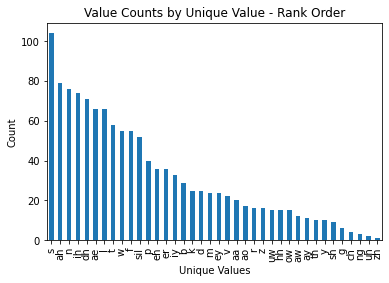

In [ ]:
import matplotlib.pyplot as plt

# get the value counts and sort them in descending order
counts = phonemes_df['phoneme'].value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('Value Counts by Unique Value - Rank Order')

# display the plot
plt.show()

#### Analyse Original Predicted Phonemes

In [ ]:
textgrid_fname = "./dataset/wsDmwoOrpR8/The False Appeal of Communism.TextGrid"
tg = TextGrid(textgrid_fname)

In [ ]:
phones = tg["phones"]

In [ ]:
phones

[<Interval text="" xmin=0.0 xmax=0.04>,
 <Interval text="DH" xmin=0.04 xmax=0.09>,
 <Interval text="IH1" xmin=0.09 xmax=0.13>,
 <Interval text="S" xmin=0.13 xmax=0.16>,
 <Interval text="IH0" xmin=0.16 xmax=0.19>,
 <Interval text="Z" xmin=0.19 xmax=0.25>,
 <Interval text="W" xmin=0.25 xmax=0.42>,
 <Interval text="AH1" xmin=0.42 xmax=0.45>,
 <Interval text="N" xmin=0.45 xmax=0.48>,
 <Interval text="TH" xmin=0.48 xmax=0.74>,
 <Interval text="IH1" xmin=0.74 xmax=0.8>,
 <Interval text="NG" xmin=0.8 xmax=0.81>,
 <Interval text="Z" xmin=0.81 xmax=0.84>,
 <Interval text="DH" xmin=0.84 xmax=0.97>,
 <Interval text="AH0" xmin=0.97 xmax=1.01>,
 <Interval text="T" xmin=1.01 xmax=1.06>,
 <Interval text="D" xmin=1.06 xmax=1.13>,
 <Interval text="IH0" xmin=1.13 xmax=1.19>,
 <Interval text="S" xmin=1.19 xmax=1.26>,
 <Interval text="T" xmin=1.26 xmax=1.32>,
 <Interval text="IH1" xmin=1.32 xmax=1.4>,
 <Interval text="NG" xmin=1.4 xmax=1.45>,
 <Interval text="G" xmin=1.45 xmax=1.48>,
 <Interval text="W" x

In [ ]:
xmax  = np.array([p.xmax for p in phones])
xmin  = np.array([p.xmin for p in phones])
ph_s  = [p.text for p in phones]
ph_df = pd.DataFrame({"xmax": xmax, "xmin": xmin, "text": ph_s})

In [ ]:
ph_df["duration"] = xmax - xmin

In [ ]:
ph_df

,xmax,xmin,text,duration
0,0.04000,0.00,,0.04000
1,0.09000,0.04,DH,0.05000
2,0.13000,0.09,IH1,0.04000
3,0.16000,0.13,S,0.03000
4,0.19000,0.16,IH0,0.03000
...,...,...,...,...
535,50.59000,50.44,S,0.15000
536,50.67000,50.59,T,0.08000
537,50.77000,50.67,EY1,0.10000
538,50.82000,50.77,T,0.05000


### Visualise Mel Spectrogram

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def plot_mel_spectrograms(pred, text):
    fig, ax = plt.subplots(1) # nrows=1, ncols=2)

    # ax[0].set_title(f"Mel Spectogram (Predicted)")
    pred = np.swapaxes(pred, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    ax.set_title(text)
    
    return fig, ax

[]

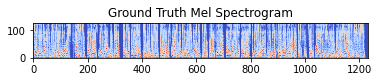

In [ ]:
audio_feats = data["audio_feats"]
fig, ax = plot_mel_spectrograms(audio_feats, "Ground Truth Mel Spectrogram")
plt.plot()

## Model

### Linear Projection (Phoneme Classification / Mel Spectrogram Prediction)

In [342]:
import torch.nn as nn

class LipToPhoneModel(nn.Module):
    """Linear Projection from AV-HuBERT Embedding to Phone / Speech Features"""
    def __init__(self, ins, hidden, outs, dropout=0.5):
        super(LipToPhoneModel, self).__init__()

        print("Init start")

        self.fc1 = nn.Linear(ins, hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden, outs)

        print("Init end")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

### Linear Projection (Phoneme Classification) with Mel Spectrogram Prediction Auxilliary Learning Task

In [343]:
import torch.nn as nn

class LipToPhoneAuxillaryModel(nn.Module):
    """Linear Projection from AV-HuBERT Embedding to Phone and Speech Features"""
    def __init__(self, ins, hidden, main_outs, aux_outs, dropout=0.5):
        super(LipToPhoneAuxillaryModel, self).__init__()

        print("Init start")

        self.fc1 = nn.Linear(ins, hidden)
        self.dropout = nn.Dropout(p=dropout)
        self.relu = nn.ReLU()
        self.fc_main = nn.Linear(hidden, main_outs)
        self.fc_aux  = nn.Linear(hidden, aux_outs)

        print("Init end")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        main = self.fc_main(x)
        aux  = self.fc_aux(x)

        return main, aux

## Trainset and Testset

### Set Random Seed

In [345]:
import numpy as np
import random
import torch
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

### All Possible Data

In [311]:
# avhubert_feats = data["av_hubert"]
avhubert_feats = data["av_hubert_large"]
phonemes       = data["phonemes"]
audio_feats    = data["audio_feats"]
avhubert_feats.shape, phonemes.shape, audio_feats.shape

(torch.Size([1234, 1024]), (1232,), (1232, 128))

In [312]:
data["phonemes"].shape

(1232,)

### Define Input, Output

In [313]:
device = "cuda"

In [314]:
# x_s = landmarks_s_arr
x_s = avhubert_feats
y_s = phonemes
# y_s = audio_feats
y_aux_s = audio_feats

### Randomise Order (K-Folds Acc Doubled)

In [315]:
print(x_s.shape[0], y_s.shape[0])
seq_len = min(x_s.shape[0], y_s.shape[0])
x_s = x_s[:seq_len, :]
y_s = y_s[:seq_len]
y_aux_s = y_aux_s[:seq_len, :]
print(x_s.shape[0], y_s.shape[0], y_aux_s.shape[0])
assert x_s.shape[0] == y_s.shape[0]
random_idxs = np.random.permutation(x_s.shape[0])
x_s = x_s[random_idxs]
y_s = y_s[random_idxs]
y_aux_s = y_aux_s[random_idxs]

1234 1232
1232 1232 1232


In [316]:
x_s.shape, y_s.shape, y_aux_s.shape

(torch.Size([1232, 1024]), (1232,), (1232, 128))

In [317]:
x_s.dtype

torch.float32

In [318]:
import torch
# CUDA_LAUNCH_BLOCKING=1
x_s = torch.tensor(x_s, dtype=torch.float).to(device)
# y_s = torch.tensor(y_s, dtype=torch.float).to("cuda")
y_s = torch.tensor(y_s, dtype=torch.long).to(device)
y_aux_s = torch.tensor(y_aux_s, dtype=torch.float).to("cuda")

/tmp/ipykernel_45600/4041233872.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_s = torch.tensor(x_s, dtype=torch.float).to(device)


In [319]:
# (seq_len, 98, 2) => (seq_len, 196)
x_s = x_s.view(x_s.shape[0], -1)

In [320]:
# Verify `x_s`` and `y_s` shape
x_s.shape, y_s.shape, y_aux_s.shape

(torch.Size([1232, 1024]), torch.Size([1232]), torch.Size([1232, 128]))

In [321]:
dataset_ratio = 0.8
dataset_size  = min(x_s.shape[0], y_s.shape[0], y_aux_s.shape[0])
print(dataset_size)

1232


In [322]:
x_s = x_s[0:dataset_size, :]

In [323]:
train_x_s = x_s[0:int(dataset_size * dataset_ratio), :]
test_x_s  = x_s[int(dataset_size * dataset_ratio):,  :]

In [324]:
y_s = y_s[0:dataset_size]

In [325]:
train_y_s = y_s[0:int(dataset_size * dataset_ratio)]
test_y_s  = y_s[int(dataset_size * dataset_ratio):]

In [326]:
y_aux_s = y_aux_s[0:dataset_size, :]

In [327]:
train_y_aux_s = y_aux_s[0:int(dataset_size * dataset_ratio)]
test_y_aux_s  = y_aux_s[int(dataset_size * dataset_ratio):]

In [328]:
x_s.shape, y_s.shape, train_x_s.shape, train_y_s.shape, train_y_aux_s.shape, test_x_s.shape, test_y_s.shape, test_y_aux_s.shape

(torch.Size([1232, 1024]),
 torch.Size([1232]),
 torch.Size([985, 1024]),
 torch.Size([985]),
 torch.Size([985, 128]),
 torch.Size([247, 1024]),
 torch.Size([247]),
 torch.Size([247, 128]))

In [329]:
y_s.shape

torch.Size([1232])

In [330]:
print(group_adjacent_duplicates(get_phone_list(y_s)))

['s', 'ih', 'r', 'm', 'er', 'p', 'r', 'f', 'v', 'sh', 'th', 'ah', 'ae', 'ih', 'm', 'w', 'eh', 'n', 's', 'f', 'r', 'f', 'ae', 'l', 'ah', 'ih', 's', 'ih', 'aa', 'w', 'p', 'm', 'n', 'dh', 'b', 'ah', 'ey', 'ae', 'n', 'ow', 'w', 'd', 'sh', 'k', 'ae', 's', 'f', 'p', 'b', 'ae', 'd', 'aa', 'ae', 'sil', 'l', 'ah', 'iy', 'sil', 's', 'm', 'v', 'r', 'er', 'ch', 'sil', 'ah', 'd', 'ae', 'l', 'hh', 'ae', 'b', 'n', 'd', 'y', 'dh', 'f', 's', 'sil', 'dh', 'ah', 'ih', 'p', 'sil', 's', 'p', 'dh', 'ah', 'l', 'ah', 'l', 's', 'ey', 'ih', 't', 'eh', 'iy', 'l', 'w', 'f', 'w', 'eh', 'aw', 'dh', 's', 'er', 'dh', 'sil', 'm', 'ah', 'n', 'er', 'sil', 's', 'dh', 'n', 'b', 'z', 'sil', 's', 'dh', 'ae', 'ih', 't', 'sil', 'z', 'eh', 'dh', 'f', 'dh', 'iy', 'w', 'p', 'ah', 't', 'r', 'ae', 'hh', 's', 'ah', 'n', 'iy', 'd', 'ey', 'ay', 'dh', 'f', 'th', 'er', 's', 'ih', 'n', 'l', 'aw', 'uw', 's', 'sil', 'ey', 'f', 'b', 'f', 'l', 'n', 't', 's', 'w', 'n', 'dh', 'iy', 'sil', 't', 'iy', 'aa', 'n', 'w', 'p', 'w', 'eh', 'aa', 'er',

### BatchDim for Seq Models

In [331]:
# x_s = x_s.unsqueeze(0)
# y_s = y_s.unsqueeze(0)

In [332]:
print("FINAL SHAPES:")
x_s.shape, y_s.shape, y_aux_s.shape

FINAL SHAPES:


(torch.Size([1232, 1024]), torch.Size([1232]), torch.Size([1232, 128]))

In [333]:
y_s.shape[-1]

1232

## Train (Overfit) - Phoneme Classification (SKLearn)

In [346]:
x_s.shape, y_s.shape

(torch.Size([1232, 1024]), torch.Size([1232]))

In [347]:
svm_x_s.shape, svm_y_s.shape

(torch.Size([1232, 1024]), torch.Size([1232]))

In [348]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

svm_x_s = x_s.cpu().detach()
svm_y_s = y_s.cpu().detach()

clf_s = ["svm", "random_forest", "neural_network"]
for clf_n in clf_s:
    if clf_n == "svm":
        clf = svm.SVC(kernel='linear')
    elif clf_n == "random_forest":
        clf = RandomForestClassifier(n_estimators=100)
    elif clf_n == "neural_network":
        clf = MLPClassifier(max_iter=1000)

    clf.fit(svm_x_s, svm_y_s)
    y_pred = clf.predict(svm_x_s)
    accuracy = accuracy_score(svm_y_s, y_pred)
    print("Classifier", clf_n, "Accuracy:", accuracy)

Classifier svm Accuracy: 1.0
Classifier random_forest Accuracy: 1.0
Classifier neural_network Accuracy: 1.0


In [277]:
svm_y_s[0:20], y_pred[0:20]

(tensor([27,  0, 14, 22,  3, 23, 29, 27, 36, 19, 16, 20, 14, 10, 36,  1,  1, 39,
          1, 38]),
 array([27,  0, 14, 22,  3, 23, 29, 27, 36, 19, 16, 20, 14, 10, 36,  1,  1,
        39,  1, 38]))

In [278]:
single_svm_x_s = svm_x_s[0]
single_svm_y_s = svm_y_s[0].item()
single_svm_x_s.shape, single_svm_y_s

(torch.Size([1024]), 27)

In [279]:
single_svm_x_s = single_svm_x_s.unsqueeze(0)
single_svm_x_s.shape

torch.Size([1, 1024])

In [280]:
single_y_pred = clf.predict(single_svm_x_s)
single_y_pred

array([27])

## Train (Generalise) - Phoneme Classification (SKLearn + K-Folds)

In [349]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

kernels = ["linear", "poly", "rbf", "sigmoid"]

svm_train_x_s = train_x_s.cpu().detach()
svm_train_y_s = train_y_s.cpu().detach()
svm_test_x_s = test_x_s.cpu().detach()
svm_test_y_s = test_y_s.cpu().detach()


def run_kfolds(model, x, y, splits):
    kf = KFold(n_splits=splits, shuffle=True)
    scores = cross_val_score(model, x, y, cv=kf, scoring="accuracy")
    return scores

# clf_s = ["svm", "random_forest", "neural_network"]
clf_s = ["neural_network"]
for clf_n in clf_s:
    if clf_n == "svm":
        clf = svm.SVC(kernel='linear')
    if clf_n == "svm":
        for kernel in kernels:
            clf = svm.SVC(kernel=kernel)
            # clf.fit(svm_train_x_s, svm_train_y_s)
            # svm_y_pred = clf.predict(svm_test_x_s)
            # accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
            scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
            print(
                "Classifier", clf_n,
                "Kernel:", kernel,
                "Scores:", scores,
                "Scores(mean):", scores.mean())
    elif clf_n == "random_forest":
        clf = RandomForestClassifier(n_estimators=100)
        #clf.fit(svm_train_x_s, svm_train_y_s)
        #svm_y_pred = clf.predict(svm_test_x_s)
        #accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
        scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
        print(
            "Classifier", clf_n,
            "Kernel:", kernel,
            "Scores:", scores,
            "Scores(mean):", scores.mean())
    elif clf_n == "neural_network":
        clf = MLPClassifier(hidden_layer_sizes=(512), max_iter=200)
        # clf.fit(svm_train_x_s, svm_train_y_s)
        # svm_y_pred = clf.predict(svm_test_x_s)
        # accuracy = accuracy_score(svm_test_y_s, svm_y_pred)
        scores = run_kfolds(clf, svm_x_s, svm_y_s, splits=5)
        print(
            "Classifier", clf_n,
            "Kernel:", kernel,
            "Scores:", scores,
            "Scores(mean):", scores.mean())

Classifier neural_network Kernel: sigmoid Scores: [0.62753036 0.63157895 0.64227642 0.56910569 0.6300813 ] Scores(mean): 0.6201145452750074


## Train (Overfit) - Mel Spectrogram (Neural Network)

In [350]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    512,
    y_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.MSELoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        pred = model(x_s)

        assert pred.shape[0] == y_s.shape[0]
        cur_pred = pred
        cur_y    = y_s
        #pred_phones = cur_pred.argmax(-1)
        #y_phones = cur_y
        # print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        loss = criteria(cur_pred, cur_y)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                #test_pred_phones = test_pred.argmax(-1)
                #test_y_phones = y_s
                #correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
            )
                # f"{acc:.2%}",
                # "\n",
                # print_phone_list(test_pred_phones),
                # "\n",
                # print_phone_list(test_y_phones),
                # "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 1232


RuntimeError: Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#cublasApi_reproducibility

### Visualise Mel Spectrogram

In [153]:
from matplotlib import cm

def plot_mel_spectrogram(mel_spec, title):
    fig, ax = plt.subplots(1)

    ax.set_title(f"Mel Spectrogram \"{title}\"")
    pred = np.swapaxes(mel_spec, 0, 1)
    cax = ax.imshow(pred, interpolation='nearest', cmap=cm.coolwarm, origin='lower')

    return fig

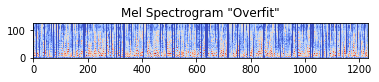

In [154]:
_ = plot_mel_spectrogram(cur_pred.cpu().detach().float(), "Overfit")

## Train (Generalise) - Mel Spectrogram (Neural Network)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 128
0 48.19505310058594 47.399009704589844 0.0001
1000 3.5627055168151855 5.870646953582764 0.0001
2000 2.0417182445526123 5.154745578765869 0.0001
3000 1.3072969913482666 5.174712657928467 1e-05
4000 1.244376301765442 5.197429656982422 1e-05
5000 1.166894555091858 5.22865629196167 1e-05
6000 1.0777584314346313 5.272486686706543 1.0000000000000002e-06
7000 1.0674446821212769 5.277418613433838 1.0000000000000002e-06
8000 1.055605173110962 5.284145355224609 1.0000000000000002e-06
9000 1.0425236225128174 5.290445327758789 1.0000000000000002e-07


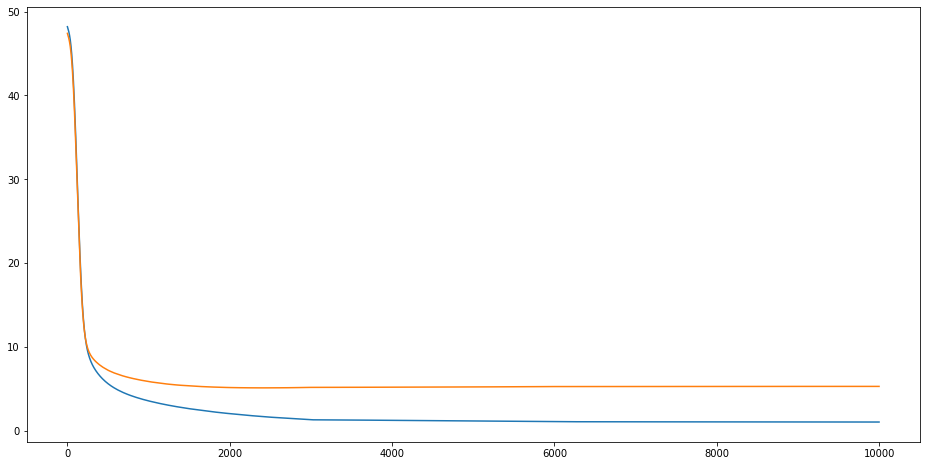

In [165]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    256,
    train_y_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10_000
lr = 1e-4

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []
scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=3000, gamma=0.1)

pred_s = []

criteria = nn.MSELoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        pred = model(train_x_s)

        # print("pred.shape[0], train_y_s.shape[0]:", pred.shape, train_y_s.shape)
        assert pred.shape[0] == train_y_s.shape[0]
        cur_pred = pred
        cur_y    = train_y_s
        #pred_phones = cur_pred.argmax(-1)
        #y_phones = cur_y
        # print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        loss = criteria(cur_pred, cur_y)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            vlosses_s.append(test_loss.detach().item())
            #test_pred_phones = test_pred.argmax(-1)
            #test_y_phones = y_s
            #correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #acc = correct_phones / test_pred_phones.shape[-1]
        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
            )
                # f"{acc:.2%}",
                # "\n",
                # print_phone_list(test_pred_phones),
                # "\n",
                # print_phone_list(test_y_phones),
                # "\n")
            
        model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    scheduler.step()

plt.plot(losses_s)
plt.plot(vlosses_s)

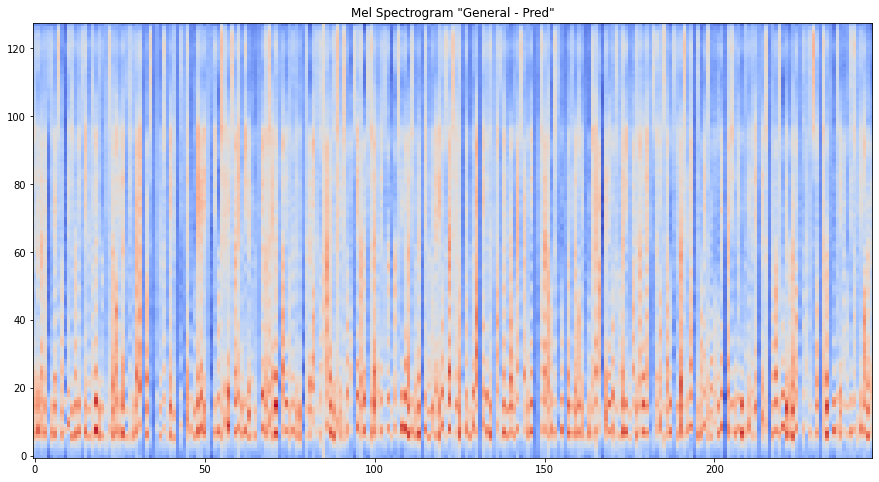

In [166]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (16,8)
_ = plot_mel_spectrogram(test_pred.cpu().detach().float(), "General - Pred")

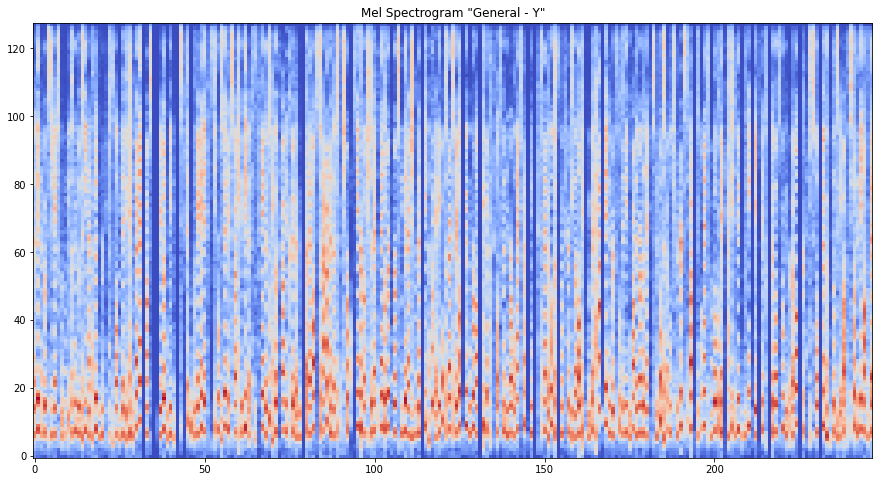

In [167]:
_ = plot_mel_spectrogram(test_y_s.cpu().detach().float(), "General - Y")

## Train (Overfit) - Phone (Neural Network)

In [ ]:
def get_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    return d

In [ ]:
def print_phone_list(phones):
    d = [dataset.phoneme_dict[int(ph_id)]
        if ph_id < len(dataset.phoneme_dict)
        else -1
        for ph_id in phones]
    print(d)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 1232
['eh', 'b', 'f', 'd', 'eh', 'uw', 'v', 'v', 'r', 'eh', 'v', 'v', 'eh', 'v', 'v', 'v', 'v', 'b', 'eh', 'd', 'dh', 'dh', 'v', 'v', 'y', 'v', 'r', 'uw', 'b', 'dh', 'v', 'v', 'n', 'b', 'v', 'v', 'uw', 'd', 't', 'v', 'v', 'v', 'v', 'v', 'v', 'iy', 'v', 'v', 'v', 'iy', 'ch', 'v', 'v', 'th', 'v', 'v', 'uw', 'v', 'v', 'th', 'eh', 'v', 'y', 'y', 'iy', 'v', 'v', 'eh', 'v', 'v', 'th', 'v', 'v', 'f', 'v', 'f', 'r', 'v', 'v', 'd', 'er', 'v', 'f', 'dh', 'th', 'v', 'v', 'iy', 'aa', 'f', 'v', 'iy', 'eh', 'f', 'eh', 'y', 'r', 'th', 'v', 'v', 'r', 'th', 'v', 'eh', 'r', 'v', 'v', 'd', 'v', 'v', 'y', 'd', 'y', 'y', 'v', 'v', 'v', 'f', 'w', 'uh', 'r', 'v', 'eh', 'v', 'v', 'f', 'y', 'r', 'th', 'v', 'f', 'v', 'v', 'y', 'v', 'v', 'd', 'f', 'v', 'uh', 'v', 'eh', 'w', 'v', 'eh', 'eh', 'b', 'y', 'b', 'd', 'v', 'v', 'eh', 'r', 'w', 'r', 'v', 'v', 'eh', 'y', 'y', 'r', 'aa', 'n', 'eh', 'uw', 'v', 'sil', 'd', 'f', 'v', 'uw', 'v', 'r', '

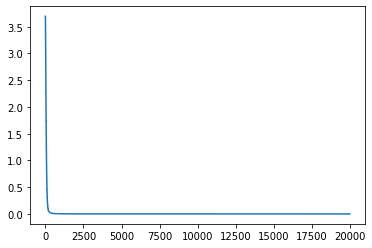

In [ ]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneModel(
    x_s.shape[-1],
    256,
    len(dataset.phoneme_dict)).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.Adam(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred = model(x_s)
                test_loss = criteria(test_pred, y_s)
                test_pred_phones = test_pred.argmax(-1)
                test_y_phones = y_s
                correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
                #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
                acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{acc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

## Train (Generalise) - Phone (Neural Network)

device: cuda
train_x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 985
['z', 'er', 'd', 'd', 'b', 'v', 'd', 'v', 'v', 'aa', 'd', 'd', 'v', 'v', 'v', 'z', 'uw', 'z', 'd', 'aa', 'sil', 'd', 'f', 'd', 'z', 'd', 'f', 'v', 'v', 'd', 'ng', 'ae', 'd', 'd', 'ch', 'd', 'dh', 'd', 'd', 'd', 'd', 'd', 'd', 'uw', 'd', 'd', 'd', 'z', 'z', 'v', 'oy', 'd', 'd', 'f', 'dh', 'd', 's', 'd', 'b', 'd', 'uw', 'z', 'sil', 'v', 'w', 'd', 'ae', 'd', 'ng', 'ae', 'd', 'w', 'er', 'v', 'ng', 'ng', 'ng', 'aa', 'aa', 'r', 'd', 'd', 'v', 'd', 'd', 'f', 'd', 'k', 'v', 'uw', 'sh', 'd', 'v', 'b', 'oy', 'dh', 'v', 'v', 'v', 'uw', 'd', 'd', 'oy', 'sil', 'k', 'z', 'f', 'k', 'ng', 'dh', 'f', 'd', 'ng', 'd', 'ng', 'v', 'oy', 'k', 'd', 'd', 'v', 'ae', 'sil', 'd', 'v', 'uw', 'd', 'dh', 'z', 'k', 'v', 'ch', 'd', 'sil', 'd', 'ch', 'd', 'sil', 'k', 'd', 'd', 'd', 'er', 'v', 'v', 'd', 'oy', 'f', 'ng', 'w', 'ae', 'd', 'd', 'aa', 'd', 'f', 'uw', 'oy', 'r', 'ae', 'b', 'd', 'v', 'd', 'd', 'aa', 'd', 'd', 'd', 'hh', 'ng'

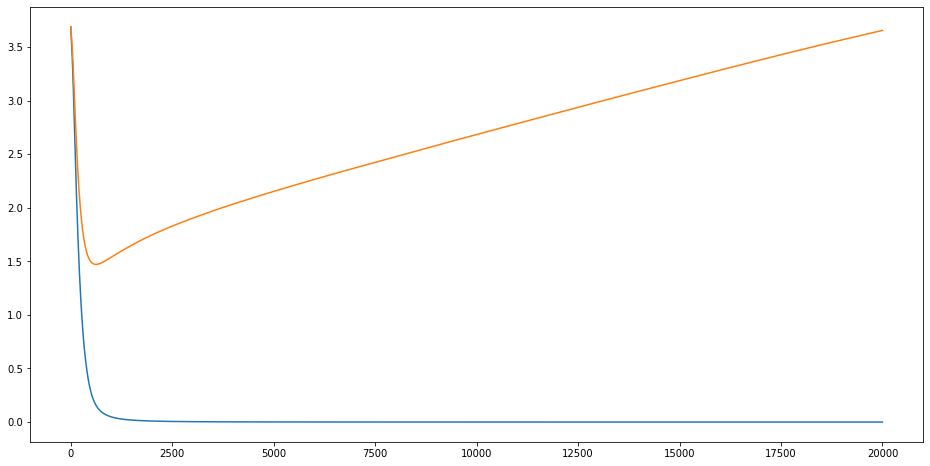

Text(0.5, 1.0, 'Peak Acc: 100.00%, Peak VAcc: 62.75%')

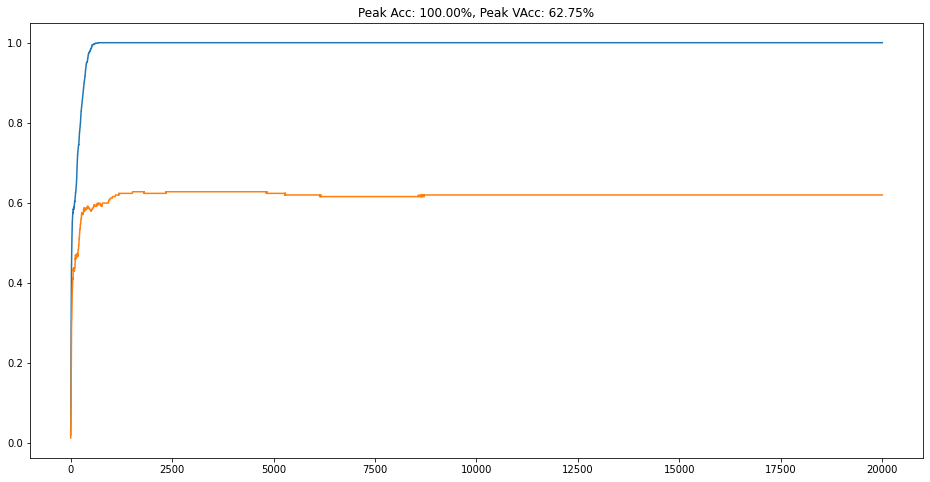

In [307]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("train_x_s.device:", train_x_s.device)

amp = True

model = LipToPhoneModel(
    train_x_s.shape[-1],
    256,
    len(dataset.phoneme_dict),
    dropout=0.5).to(device)

print("y_s.shape[-1] original:", train_y_s.shape[-1])
epochs = 20_000
lr = 1e-4 # 5e-5

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=epochs, gamma=0.1)

pred_s = []

acc_s = []
vacc_s = []
criteria = nn.CrossEntropyLoss()

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=False,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred = model(train_x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = train_y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == train_y_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = train_y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        loss = criteria(cur_pred, cur_y)
        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        acc = correct_phones / pred_phones.shape[-1]
        acc_s.append(acc)
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred = model(test_x_s)
            test_loss = criteria(test_pred, test_y_s)
            test_pred_phones = test_pred.argmax(-1)
            test_y_phones = test_y_s
            correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
            #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
            vacc = correct_phones / test_pred_phones.shape[-1]
            vacc_s.append(vacc)
            vlosses_s.append(test_loss.detach().item())

        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{vacc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
        model.train()
        
        # print(pred, y)
        # losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(test_loss)
    scheduler.step()

plt.plot(losses_s)
plt.plot(vlosses_s)
plt.show()
plt.plot(acc_s)
plt.plot(vacc_s)
plt.title(f"Peak Acc: {max(acc_s):.2%}, Peak VAcc: {max(vacc_s):.2%}")

### Test Set Phoneme Distribution

In [118]:
print_phone_list(test_y_s)
#test_y_ph_lst = get_phone_list(test_y_phones.cpu())
## test_y_ph_lst = group_adjacent_duplicates(test_y_ph_lst)
#print(test_y_ph_lst)

['dh', 'z', 'b', 'n', 'l', 'p', 'n', 'ih', 'ng', 'hh', 's', 'z', 'n', 'w', 's', 'p', 'ih', 'p', 'ih', 's', 'eh', 'ah', 'k', 'p', 'd', 'w', 'f', 's', 'w', 'ao', 'd', 'ae', 'dh', 'sh', 'f', 'b', 'dh', 't', 'k', 's', 's', 'ae', 'sh', 'ae', 'dh', 'ow', 'aw', 's', 'p', 'aw', 't', 'l', 'w', 'eh', 'w', 'dh', 'ay', 'uw', 'ao', 's', 'er', 'ao', 'ih', 'ao', 'iy', 'ey', 'y', 'l', 'ae', 'f', 'ah', 'z', 'n', 'l', 'w', 'f', 'ae', 'n', 'ao', 'p', 'v', 'sil', 'p', 'ae', 'iy', 'ao', 's', 'p', 's', 'ae', 'l', 'eh', 'sil', 't', 'z', 'iy', 'ae', 'n', 'l', 'ae', 's', 'aa', 'b', 'f', 'er', 'sil', 'l', 't', 'w', 'f', 'ih', 'ih', 'n', 'l', 'l', 'p', 'n', 's', 'dh', 'sil', 'ah', 'ey', 't', 'ey', 'w', 'z', 'ih', 'er', 'hh', 's', 'dh', 'n', 't', 's', 'uw', 'sil', 'ae', 'f', 'f', 'w', 'n', 'sil', 's', 'd', 'p', 'f', 'p', 'b', 's', 'w', 'n', 's', 'ae', 'b', 'v', 'ah', 'ah', 'sil', 'ey', 'w', 'ae', 'v', 'sil', 'l', 'l', 'er', 'dh', 't', 'aw', 's', 'iy', 'l', 'dh', 'aa', 'dh', 'ow', 'ih', 'ey', 's', 's', 'ih', 'ah',

(247, 1)


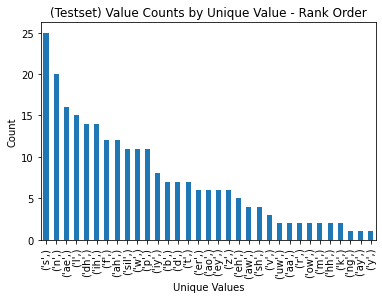

In [119]:
import matplotlib.pyplot as plt

test_y_df = pd.DataFrame(columns=["phoneme"], data=[dataset.phoneme_dict[d]
                                                    for d in test_y_phones.cpu()])

# get the value counts and sort them in descending order
counts = test_y_df.value_counts().sort_values(ascending=False)

# create a bar chart of the counts
fig, ax = plt.subplots()
counts.plot.bar(ax=ax)

# set the x-axis labels to the unique values
ax.set_xticklabels(counts.index)

# set the axis labels and title
ax.set_xlabel('Unique Values')
ax.set_ylabel('Count')
ax.set_title('(Testset) Value Counts by Unique Value - Rank Order')

# display the plot
print(test_y_df.shape)
plt.show()

### Phoneme Prediction Confusion Matrix

In [120]:
cm_pred = test_pred_phones.cpu()

In [121]:
cm_y = test_y_phones.cpu()

In [122]:
cm_y

tensor([21, 26, 39, 22, 36, 20, 22,  2, 25,  6,  1, 26, 22, 38,  1, 20,  2, 20,
         2,  1, 18, 13, 31, 20, 37, 38, 16,  1, 38, 29, 37, 12, 21,  3, 16, 39,
        21, 14, 31,  1,  1, 12,  3, 12, 21, 30, 33,  1, 20, 33, 14, 36, 38, 18,
        38, 21,  4, 23, 29,  1, 27, 29,  2, 29,  5, 15, 10, 36, 12, 16, 13, 26,
        22, 36, 38, 16, 12, 22, 29, 20, 24,  0, 20, 12,  5, 29,  1, 20,  1, 12,
        36, 18,  0, 14, 26,  5, 12, 22, 36, 12,  1, 19, 39, 16, 27,  0, 36, 14,
        38, 16,  2,  2, 22, 36, 36, 20, 22,  1, 21,  0, 13, 15, 14, 15, 38, 26,
         2, 27,  6,  1, 21, 22, 14,  1, 23,  0, 12, 16, 16, 38, 22,  0,  1, 37,
        20, 16, 20, 39,  1, 38, 22,  1, 12, 39, 24, 13, 13,  0, 15, 38, 12, 24,
         0, 36, 36, 27, 21, 14, 33,  1,  5, 36, 21, 19, 21, 30,  2, 15,  1,  1,
         2, 13, 33, 16,  1, 39,  5, 16, 36, 12, 13,  1, 12, 22, 22,  0, 18, 22,
         2, 35, 35, 13, 39, 16, 21,  5, 22,  1, 12, 12, 27, 13,  0, 21, 13, 18,
         1, 36, 27, 26, 37, 13,  5, 22, 

In [123]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(cm_y, cm_pred)

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# labels = np.unique(cm_y)
# phone_dict_idxs = list(range(len(dataset.phoneme_dict)))
labels = np.unique(torch.concat((cm_y, cm_pred), dim=0))

labels = [dataset.phoneme_dict[ph] for ph in labels]

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=labels, yticklabels=labels)

# Set labels and title
plt.xlabel('Predicted Phonemes')
plt.ylabel('True Phonemes')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

ValueError: Must pass 2-d input. shape=()

<Figure size 864x576 with 0 Axes>

In [125]:
cm

array([[ 8,  0,  0, ...,  0,  0,  0],
       [ 0, 18,  0, ...,  0,  0,  0],
       [ 0,  2,  8, ...,  0,  0,  0],
       ...,
       [ 0,  0,  0, ...,  2,  0,  0],
       [ 0,  0,  0, ...,  1,  9,  0],
       [ 1,  0,  0, ...,  0,  0,  5]])

In [126]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Extracting true negatives, false positives, false negatives, true positives
# tn, fp, fn, tp = cm[0, 0], cm[0, 1], cm[1, 0], cm[1, 1]

# Compute evaluation metrics
accuracy   = accuracy_score(cm_y, cm_pred)
precision  = precision_score(cm_y, cm_pred, average="micro")
recall     = recall_score(cm_y, cm_pred, average="micro")
f1         = f1_score(cm_y, cm_pred, average="micro")

# Print confusion matrix and evaluation metrics
print("Confusion Matrix:")
print(cm)
# print("True Negatives:", tn)
# print("False Positives:", fp)
# print("False Negatives:", fn)
# print("True Positives:", tp)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
[[ 8  0  0 ...  0  0  0]
 [ 0 18  0 ...  0  0  0]
 [ 0  2  8 ...  0  0  0]
 ...
 [ 0  0  0 ...  2  0  0]
 [ 0  0  0 ...  1  9  0]
 [ 1  0  0 ...  0  0  5]]
Accuracy: 0.6518218623481782
Precision: 0.6518218623481782
Recall: 0.6518218623481782
F1 Score: 0.6518218623481782


## Train (Overfit) - Phone (Neural Network + Aux Tas)

In [289]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneAuxillaryModel(
    x_s.shape[-1],
    256,
    len(dataset.phoneme_dict),
    y_aux_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 10000
lr = 1e-3

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

criteria = nn.CrossEntropyLoss()
aux_criteria = nn.MSELoss()
aux_lambda = 0.1 # weight the auxilliary learning task much smaller

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred, aux_pred = model(x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == y_s.shape[0]
        assert aux_pred.shape[0] == y_aux_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        
        loss = criteria(cur_pred, cur_y) + aux_criteria(aux_pred, y_aux_s)

        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        if epoch_idx % 1000 == 0:
            # test
            model.eval()
            with torch.no_grad():
                test_pred, test_aux = model(x_s)
                test_loss = criteria(test_pred, y_s) + aux_criteria(test_aux, y_aux_s)
                test_pred_phones = test_pred.argmax(-1)
                test_y_phones = y_s
                correct_phones = (test_pred_phones == test_y_phones).sum().item()
                #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
                #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
                acc = correct_phones / test_pred_phones.shape[-1]
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{acc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)


plt.plot(losses_s)

device: cuda
x_s.device: cuda:0
Init start
Init end
y_s.shape[-1] original: 1232
['ey', 'aa', 'uw', 'd', 'v', 'iy', 'aa', 'd', 'aa', 'aa', 'aa', 'uw', 'ow', 'p', 'd', 'p', 'uw', 'aw', 'aa', 'p', 'aw', 'aa', 'sil', 'd', 'aa', 'aa', 'aa', 'uw', 'aa', 'v', 'p', 'aa', 'sh', 'aa', 'aw', 'iy', 'p', 'p', 'aa', 'aa', 'p', 'p', 'oy', 'aw', 'aa', 'd', 'aa', 'iy', 'ow', 'd', 'hh', 'ow', 'aa', 'uw', 'aw', 'aa', 'aw', 'uw', 'v', 'p', 'aw', 'aa', 't', 'd', 'uw', 'p', 'aa', 'uw', 'd', 'aw', 's', 'y', 'd', 's', 'uw', 'g', 'd', 'uw', 'ow', 'd', 'zh', 'oy', 'v', 'aa', 'd', 'jh', 'd', 'd', 'aa', 's', 'oy', 'uw', 'p', 'd', 'v', 'd', 'oy', 'ow', 'aw', 'iy', 'uw', 'aw', 'd', 'aa', 's', 'd', 'g', 'd', 'aa', 's', 'y', 'd', 'uw', 'iy', 'er', 'aa', 'd', 'v', 'aa', 'ow', 'p', 'zh', 'p', 'p', 'aa', 'd', 'd', 'aa', 'd', 'aa', 'uw', 'ow', 'aa', 'zh', 'p', 'aa', 'p', 'aa', 'uw', 'aw', 'aa', 'p', 'g', 'p', 'aa', 'sil', 'd', 'd', 'sh', 'p', 'aa', 'aa', 'd', 'aa', 'p', 'v', 'aw', 'oy', 'aw', 's', 'p', 'aa', 'aw', 'aw',

KeyboardInterrupt: 

## Train (Generalise) - Phone (Neural Network + Aux Tas)

In [ ]:
from torch.cuda.amp        import autocast, GradScaler
import matplotlib.pyplot   as plt
import torch.nn.functional as F
import torch

print("device:", device)
print("x_s.device:", x_s.device)

amp = True

model = LipToPhoneAuxillaryModel(
    x_s.shape[-1],
    256,
    len(dataset.phoneme_dict),
    y_aux_s.shape[-1]).to(device)

print("y_s.shape[-1] original:", y_s.shape[-1])
epochs = 20000
lr = 1e-4

# optim = torch.optim.AdamW(params=model.parameters(), lr=lr)
optim = torch.optim.AdamW(params=model.parameters(), lr=lr)

losses_s = []
vlosses_s = []

scaler = GradScaler()
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, 'min')
# scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.1)

pred_s = []

acc_s = []
vacc_s = []

criteria = nn.CrossEntropyLoss()
aux_criteria = nn.L1Loss() # (Mean Absolute Error)
aux_lambda = 0.0 # weight the auxilliary learning task much smaller

model.train()
for epoch_idx in range(epochs):
    with autocast(
        enabled=True,
        dtype=torch.bfloat16):

        # print("pre model x_s.shape:", x_s.shape)
        pred, aux_pred = model(train_x_s)
        pred = F.log_softmax(pred, -1)
        pred_phones = pred.argmax(-1)
        y_phones = train_y_s
        # pred_code = dataset.decode(pred[0])

        assert pred.shape[0] == train_y_s.shape[0]
        assert aux_pred.shape[0] == train_y_aux_s.shape[0]
        # loss_iter = 1 # pred.shape[0]
        #losses = []
        #correct_phones = 0
        #total_len = 0

        #print("loss_iter:", loss_iter)
        #print("y_s.shape:", y_s.shape)
        # for iter in range(loss_iter):
            #print("pred.shape, y_s.shape:", pred.shape, y_s.shape)
        cur_pred = pred
        cur_y    = train_y_s
        pred_phones = cur_pred.argmax(-1)
        y_phones = cur_y
        #print("cur_pred.shape, cur_y.shape:", cur_pred.shape, cur_y.shape)
        #print("cur_pred.dtype, cur_y.dtype:", cur_pred.dtype, cur_y.dtype)
        
        loss = \
            criteria(cur_pred, cur_y) + \
            (aux_criteria(aux_pred, train_y_aux_s) * aux_lambda)

        #losses.append(loss)
        losses_s.append(loss.item())
        correct_phones = (pred_phones == y_phones).sum().item()
        acc = correct_phones / pred_phones.shape[-1]
        acc_s.append(acc)
        # print("pred_phones.shape, y_phones.shape:", pred_phones.shape, y_phones.shape)
        # print("correct_phones:", correct_phones, y_phones, y_phones.shape)
        #total_len += y_phones.size(0)
        #loss = sum(losses) / loss_iter

        # print(
        #     "pred.shape, y_s.shape:",
        #     pred.shape,
        #     y_s.shape,
        #     pred_phones,
        #     y_s)
        
            # print_phone_list(pred_phones),
            # print_phone_list(y_s))
        

        #loss = criteria(pred, y_s)
        # loss = F.mse_loss(pred, y_s)
        
        
        # test
        model.eval()
        with torch.no_grad():
            test_pred, test_aux = model(test_x_s)
            test_loss = \
                criteria(test_pred, test_y_s) + \
                (aux_criteria(test_aux, test_y_aux_s) * aux_lambda)
            test_pred_phones = test_pred.argmax(-1)
            test_y_phones = test_y_s
            correct_phones = (test_pred_phones == test_y_phones).sum().item()
            #print("test_pred.shape, test_pred_phones.shape:", test_pred.shape, test_pred_phones.shape)
            #print("test_pred_phones, test_y_phones", test_pred_phones, test_y_phones)
            vacc = correct_phones / test_pred_phones.shape[-1]
            vacc_s.append(vacc)
            vlosses_s.append(test_loss.detach().item())

        if epoch_idx % 1000 == 0:
            print(
                epoch_idx,
                loss.item(),
                test_loss.item(),
                optim.param_groups[0]['lr'],
                #test_pred_phones,
                f"{vacc:.2%}",
                "\n",
                print_phone_list(test_pred_phones),
                "\n",
                print_phone_list(test_y_phones),
                "\n")
            
            model.train()
        

        # print(pred, y)
        # losses_s.append(loss.detach().item())

    #loss.backward()
    #optim.step()

    scaler.scale(loss).backward()
    scaler.step(optim)
    scaler.update()
    
    # scheduler.step(loss)

plt.plot(losses_s)
plt.plot(vlosses_s)
plt.show()
plt.plot(acc_s)
plt.plot(vacc_s)
plt.title(f"Peak Acc: {max(acc_s):.2%}, Peak VAcc: {max(vacc_s):.2%}")